# "Molecular Modeling Software: ParmEd"

- toc: false
- branch: master
- badges: true
- comments: false
- categories: [grad school, molecular modeling, scientific computing]

ParmEd is an [open-source python package](https://github.com/ParmEd/ParmEd) for molecular modelling applications. 
In the description: "Cross-program parameter and topology file editor and molecular mechanical simulator engine."

The description doesn't quite do this package justice - ParmEd provides a *data structure that represents a molecular model*. Atomic names, coordinates, bonding neighbors, and *ALL the interaction parameters you would use to model a chemical system and its underlying physics* (at a molecular mechanics level, not quantum).

For a molecular modeller, this extremely important if we want to consistently and reliably build a model for a chemical system. Building these models ends up being a lot of bookkeeping (okay we'll use this value for the A-B bond but this other value for the A-B non-bonded interaction), which becomes exponentially laborious as the sorts of chemical systems diversify from hundreds of copies of the same type of atom and parameters, to thousands of copies of a dozen different types and hundreds of different parameters, to beyond.

For a scientific software developer, this is a great package in its *object-oriented design, extensive documentation, use of unit tests, open-source nature, and active user community*; active user communities are hard in academia when everyone does everything slightly differently - if you can find a common ground that everyone will use and know, then you might hit a "critical threshold" for userbase that the open-source community may yield some incredible contributions.

For both groups, this is a great package because it *facilitates interoperability between simulation engines/applications*. The world of molecular modelling has developed many simulation packages designed for a particular purpose, focused more on depth than breadth of application. *The algorithms and simulation implementations may differ, but the fundamental molecular model is the same.*

## The interconversion and interoperability issue

Here's a gripe within the simulation community: *everyone has a different file format*

One simulation engine might write bond parameters as (bondtype, r0 in Angstrom, k in kcal/mol/A^2)

1, 10, 200

Another simulation engine might go with (atomtype1, atomtype2, k in kJ/mol/nm^2, r0 in nm)

1, 2, 41840, 1

For thousands of parameter lines similar to this, keeping track of units and proper syntax and overall formatting is a huge headache, and you'd think this sort of thing should be automated. 

Another example, to express a bond as a harmonic potential, there are 2 ways to write the function

$V(r) = k * (r-r_0)^2$

$V(r) = (1/2) * k * (r-r_0)^2$

So your force constant, $k$, can be off by a factor 2 if you're not bookkeeping properly. 

In the grand scheme of interoperability, ParmEd processes these nuances between implementations upon translating to or from the `parmed.Structure` object

Let's say there are N simulation engines. Converting between each engine could be as expensive as O($N^2$) convertes.
You would have to read in engine A's file format and convert it to the proper format for engine B. And then you'd need one for A-C and B-C, etc.

What if there were a middleman? Converting between each engine would be O($2N$). This middleman is `parmed.Structure`, this massive class that contains all these parameters and coordinates and everything you need in a molecular model. The conversion procedure would be A-`Structure`-B or C-`Structure`-B. 

If you can store your model information into the `parmed.Structure`, you just need to write a routine that
parses through the `Structure` and spits the information out according to the engine. If you have the information
stored in an engine's file format, you just need to write a routine that processes that information into `parmed.Structure`

## Examining `pmd.Structure`

One popular use-case of `parmed` involves reading files to get a `pmd.Structure`. It's fairly simple
to go from some `GROMACS` files to `pmd.Structure`. In this case, we'll be looking at ethane (C2H8)

In [1]:
import parmed as pmd
my_struc = pmd.load_file('ethane_periodic.top', xyz='ethane_periodic.gro')
my_struc

<GromacsTopologyFile 8 atoms; 1 residues; 7 bonds; PBC (orthogonal); parametrized>

In this one line, all the molecular model information about bond parameters, angle parameters, dihedral parameters,
non-bonded parameters, etc. are all loaded in to `my_struc`.

Now we can start digging through the various properties within `my_struc`

`my_struc` is just a massive container for smaller containers that eventually hold numerical values. We can 
examine the bonds within `my_struc`

In [2]:
print(my_struc.bonds)

TrackedList([
	<Bond <Atom C [0]; In RES 0>--<Atom H [3]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
	<Bond <Atom C [0]; In RES 0>--<Atom H [1]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
	<Bond <Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>; type=<BondType; k=268.000, req=1.529>>
	<Bond <Atom H [2]; In RES 0>--<Atom C [0]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
	<Bond <Atom C [4]; In RES 0>--<Atom H [5]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
	<Bond <Atom H [6]; In RES 0>--<Atom C [4]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
	<Bond <Atom H [7]; In RES 0>--<Atom C [4]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
])


The string representations of these bonds is pretty helpful at a glance.
We can see the two atoms participating in the bond, and the nature of their interactions (bondtypes)
There are two different bondtypes, one for C-C and another for C-H.

Next, we can select out an individual bond and sift through the various information inside it

In [3]:
print(my_struc.bonds[0])
print(my_struc.bonds[0].type)
print(my_struc.bonds[0].type.k)

<Bond <Atom C [0]; In RES 0>--<Atom H [3]; In RES 0>; type=<BondType; k=340.000, req=1.090>>
<BondType; k=340.000, req=1.090>
339.99999999999994


We can look at the atoms similarly - we'll get the coordinates of the first atom

In [4]:
print(my_struc.atoms[0])
print(my_struc.atoms[0].xx, my_struc.atoms[0].xy, my_struc.atoms[0].xz)

<Atom C [0]; In RES 0>
0.0 -1.4000000000000001 -0.0


Before going forward, I want to introduce the term **atom type**, which describes the identity of an atom.

If you had a system of just argon atoms, they are all chemically identical. There might be a bunch of argon atoms, but there would only be one atom type

In a more complicated example, let's say you had a box of propane ![propane](/images/mm/propane_2d.png)

Looking at the carbons, there might be 3 carbons, but 2 different atom types. The "outside" carbons (each with 3 hydrogens) moieties, are chemically different from the "middle" carbon (with 2 hydrogens).

When you look at bonds, the external C-H bond might be chemically different from the inside C-H bond (they probably aren't very chemically different, but let's assume they are). As a result, while they are both C-H bonds, they will have different bond types. This sort of delination appears for angles (3 atoms bonded linearly) and dihedrals (4 atoms bonded together either linearly) and improper dihedrals (3 atoms bonded to a central atom). You might have a lot of bonds, but many fewer bond types

Let's look deeper at the atoms within `my_struc`, the atom type

In [5]:
print(my_struc.atoms[0].type)

opls_135


Not the most interesting or intuitive name, but it's still unique enough for differenting atom types

Before we go further, I have to introduce another equation that models the **non-bonded interactions** in our system. For $N$ atoms, there are $N^2$ of these. And usually non-bonded interactions are broken into coulombic (think physics 2) interactions, but also your **dispersion forces** (which arise from temporary dipole interactions that may arise between two atoms). I will focus on the **dispersion forces** - most models for this force utilize the **Lennard-Jones** potential (though some people use Buckingham, Morse, Mie, etc).

$V(r) = 4\epsilon[(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6]$

$\sigma$ and $\epsilon$ are parameters of the model, $r$ is the interatomic distance between the two atoms in question

For the atom type `opls_135`, we can examine the associated sigma and epsilon parameters

In [6]:
print(my_struc.atoms[0].sigma, my_struc.atoms[0].epsilon)

35.0 0.066


For fun, we can visualize this potential over distance

Text(0.5, 0, 'r, $\\AA$')

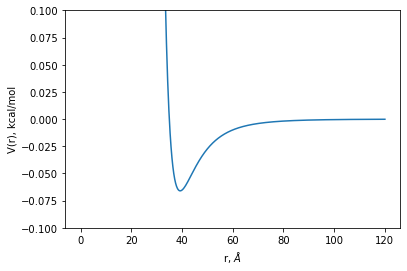

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
r = np.linspace(0.00001, 120, num=1000)
v = 4 * my_struc.atoms[0].epsilon * ((my_struc.atoms[0].sigma/r)**12 - (my_struc.atoms[0].sigma/r)**6)
fig, ax = plt.subplots(1,1)
ax.plot(r, v)
ax.set_ylim([-0.1,0.1])
ax.set_ylabel("V(r), kcal/mol")
ax.set_xlabel("r, $\AA$")

That is an introduction to the `pmd.Structure` - it is a MASSIVE container for all things related to a molecular model. This works well for molecular models with a lot of things in common. Now we will tackle the components of a molecular model are different.

## Dihedrals

A dihedral refers to the interaction between 4 linearly connected atoms. This isn't exactly chemistry, but rather an approximation to chemistry and things like steric interactions (think Neumann projections back from organic chemistry).

There a variety of ways to model this interaction. For example:

* Periodic torsions ![periodic](/images/mm/periodic_torsion.png)

* Ryckaert-Bellemans (RB) torsions ![rbtorsion](/images/mm/rb_torsion.png)

They are both trigonometric series, but there's not much commonality between them - there's not a simple underlying set of parameters/function between the two that you can easily relate. You'd have to generate some energies for one function, and then numerically fit the other. Since there's no easy way for one function/set of parameters to express both of these functions, we have to handle them separately within `pmd.Structure`

In [8]:
periodic_torsions = pmd.load_file('ethane_periodic.top', xyz='ethane_periodic.gro')
rb = pmd.load_file('ethane_rbtorsion.top', xyz='ethane_rbtorsion.gro')

`periodic_torsions` is a molecular model for ethane using periodic torsions. `rb` is a molecular model for ethane using RB torsions.

All the different interaction models/classes are found in [parmed/topologyobjects.py](https://github.com/ParmEd/ParmEd/blob/master/parmed/topologyobjects.py)

But some dihedral bookkeeping in ParmEd: periodic torsions are stored in `structure.dihedrals` while RBtorsions are stored in `structure.rb_torsions`. Handling improper dihedrals is a bigger mess, but I want to emphasize how ParmEd handles these different functional forms: they are kept as separate objects and handled separately.

The next two snippets will look at periodic torsions within `rb` and `periodic_torsions` (or lack thereof)

In [12]:
periodic_torsions.dihedrals

TrackedList([
	<Dihedral; <Atom H [1]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [5]; In RES 0>; type=<DihedralType; phi_k=0.741, per=1, phase=179.909,  scee=2.000, scnb=1.000>>
	<Dihedral; <Atom H [1]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [6]; In RES 0>; type=<DihedralType; phi_k=0.741, per=1, phase=179.909,  scee=2.000, scnb=1.000>>
	<Dihedral; <Atom H [1]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [7]; In RES 0>; type=<DihedralType; phi_k=0.741, per=1, phase=179.909,  scee=2.000, scnb=1.000>>
	<Dihedral; <Atom H [2]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [5]; In RES 0>; type=<DihedralType; phi_k=0.741, per=1, phase=179.909,  scee=2.000, scnb=1.000>>
	<Dihedral; <Atom H [2]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [6]; In RES 0>; type=<DihedralType; phi_k=0.741, per=1, phase=179.909,  scee=2.000, scnb=1.000>>
	<Dihedral; <Atom H [2]; In RES 0>--<Atom

In [13]:
rb.dihedrals

TrackedList([
])

The next two snippets will look at RB torsions within `rb` and `periodic_torsions` (or lack thereof)

In [14]:
periodic_torsions.rb_torsions

TrackedList([
])

In [15]:
rb.rb_torsions

TrackedList([
	<Dihedral; <Atom H [1]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [5]; In RES 0>; type=<RBTorsionType; c0=0.150; c1=0.450; c2=0.000; c3=-0.600; c4=0.000; c5=0.000; scee=2.0; scnb=1.0>>
	<Dihedral; <Atom H [1]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [6]; In RES 0>; type=<RBTorsionType; c0=0.150; c1=0.450; c2=0.000; c3=-0.600; c4=0.000; c5=0.000; scee=2.0; scnb=1.0>>
	<Dihedral; <Atom H [1]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [7]; In RES 0>; type=<RBTorsionType; c0=0.150; c1=0.450; c2=0.000; c3=-0.600; c4=0.000; c5=0.000; scee=2.0; scnb=1.0>>
	<Dihedral; <Atom H [2]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [5]; In RES 0>; type=<RBTorsionType; c0=0.150; c1=0.450; c2=0.000; c3=-0.600; c4=0.000; c5=0.000; scee=2.0; scnb=1.0>>
	<Dihedral; <Atom H [2]; In RES 0>--<Atom C [0]; In RES 0>--<Atom C [4]; In RES 0>--<Atom H [6]; In RES 0>; type=<RBTorsionType; c0=0.150; c1=

In the `parmed.Structure` object, the different dihedral forms are held in different containers. Regardless, the parameters relevant to each dihedral object are still tracked

# `parmed.Structure` conversion

Many like to use `parmed` as the middleman to convert from one engine's file format to another engine's file format. In this notebook, we've been using `GROMACS` files to model ethane, and now we'll mess around with converting to files suitable for other engines.

In [17]:
my_struc = pmd.load_file('ethane_periodic.top', xyz='ethane_periodic.gro')
my_struc.save('ethane_periodic.prmtop')
my_struc.save('ethane_periodic.crd')

Another molecular simulation engine, `AMBER`, specifies the molecular model in `prmtop` (parametrized topology) and `crd` (coordinate) files. I confess I haven't actually used `AMBER` (it's very popular), but `parmed` has made it incredibly easy for a `GROMACS`-user to switch over (and use functionality that `AMBER` might provide)

In [18]:
!head ethane_periodic.prmtop

%VERSION  VERSION_STAMP = V0001.000  DATE = 08/01/19  17:37:44
%FLAG TITLE
%FORMAT(20a4)

%FLAG POINTERS
%FORMAT(10I8)
       8       2       6       1      12       0       9       0       0       0
      29       1       1       0       0       2       2       9       1       0
       0       0       0       0       0       0       0       1       8       0
       0


In [19]:
!head ethane_periodic.crd

* GENERATED BY PARMED (HTTPS://GITHUB.COM/PARMED/PARMED)
*
         8  EXT
         1         1  RES       C               0.0000000000       -1.4000000000       -0.0000000000  SYS       0               0.0000000000
         2         1  RES       H              -1.0700000000       -1.4000000000       -0.0000000000  SYS       0               0.0000000000
         3         1  RES       H               0.3600000000       -2.1700000000        0.6500000000  SYS       0               0.0000000000
         4         1  RES       H               0.3600000000       -1.5800000000       -0.9900000000  SYS       0               0.0000000000
         5         1  RES       C               0.0000000000        0.0000000000        0.0000000000  SYS       0               0.0000000000
         6         1  RES       H               1.0700000000        0.0000000000        0.0000000000  SYS       0               0.0000000000
         7         1  RES       H              -0.3600000000        0.770000000

What we did with `GROMACS` files to `pmd.Structure` to `AMBER` files involed an IOstep to read `GROMACS` files into an in-memory representation, then an IO step to write `AMBER` files from the in-memory representation. These 2 simulation engines require these files to perform a simulation - what about a simulation engine that doesn't require this IO step, and we can purely handle this all in-memory?

`OpenMM` is another simulation engine rooted in CUDA and C++ with wrappers for python implementations. We can "interface" more tightly with the `OpenMM` codebase by doing all these molecular model conversions within python

In [22]:
my_omm_system = my_struc.createSystem()
print(type(my_omm_system))
my_omm_system

<class 'simtk.openmm.openmm.System'>


<simtk.openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x110c0ef00> >

In that one line, we've converted `pmd.Structure` into `openmm.System`, which gets us very close to performing a simulation within `OpenMM` without writing out an input file. 

In my opinion, this adds some elegance to performing molecular simulations in that they can be well-encompassed in a python script (and not a python script that just wraps a bunch of shell commands)

## Does this relate to other fields of technology?
Are there other applications of STEM where objects/entities need to be able to convert, communicate, or inter-operate between one another? ParmEd is a nice intermediate that allows different simulation engines to communicate information.

I recently set up a Google Home Mini in my apartment - how does the Google product know how to turn off all the different smart bulbs out there (Philips, Element, Sengled, Wyze, FluxSmart)? I'm sure there are engineers who have to work on this GoogleHome-bulb interoperability to make sure a command to Google Home will perform an action to another device. 

What about parallel computing? The MPI standard defines routines and protocols to which any MPI library must adhere (OpenMPI, MPICH, etc). This defines a common ground so that an external program can call the same MPI functions and expect the same operation, but under the hood it's a different MPI library performing the gather/recieve commands.

# Summary
ParmEd is a digital, in-memory data structure that represents a molecular model. It often serves an intermediary and great bookkeeper to facilitate translating molecular model (parameters, topology, coordinates) information from one simulation's file format (or data structure) to another simulation's file format (or data structure). It supports a variety of functional forms for the molecular modellers out there, and it is well-designed for the scientific software developers out there. Any molecular modeller knows how difficult and laborious this sort of package is, so the contributors to ParmEd deserve a big thank you.